# Package import

Used "SOCOFing" dataset: https://www.kaggle.com/datasets/ruizgara/socofing

In [3]:
import os
import random
import itertools
import numpy as np
import seaborn as sns
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimgP
import datetime
import tensorflow as tf
import skimage as si
import math
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
from scipy.ndimage import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy import ndimage
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Feature extraction (step by step)

## Import and process image


In [4]:
DATA_DIR = "./Real/"
images = glob.glob(DATA_DIR + "*.BMP")

#count images
print(len(images))

6000


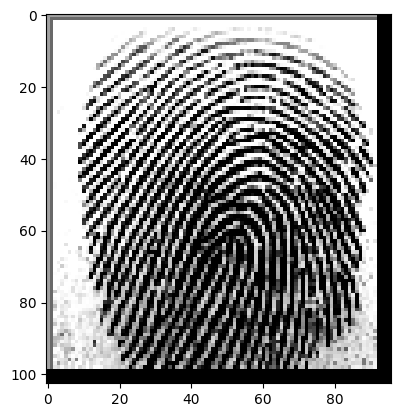

In [5]:
image = cv2.imread(images[0])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

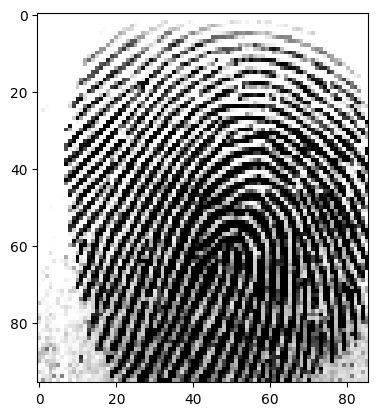

In [6]:
# Crop image to remove strange border coming from data
left = 2
top = 2
right = 88
bottom = 98
imgcropped = gray[top:bottom,left:right]
plt.imshow(imgcropped, cmap='gray')

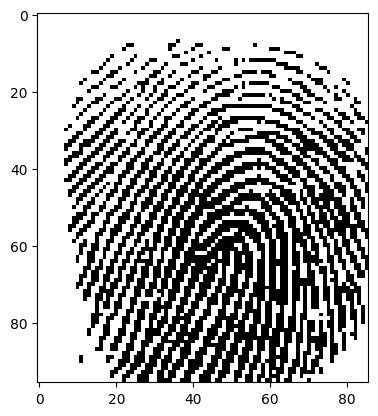

In [7]:
_,th = cv2.threshold(imgcropped,80,255,cv2.THRESH_BINARY)
plt.imshow(th, cmap='gray')

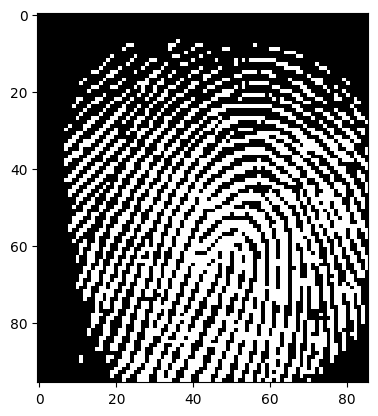

In [8]:
# Binarized image 0-255 to binary image 0-1
th_inv = np.invert(th)
bin_img = np.array(th_inv/th_inv.max(),dtype=np.uint8)

plt.imshow(th_inv, cmap='gray')

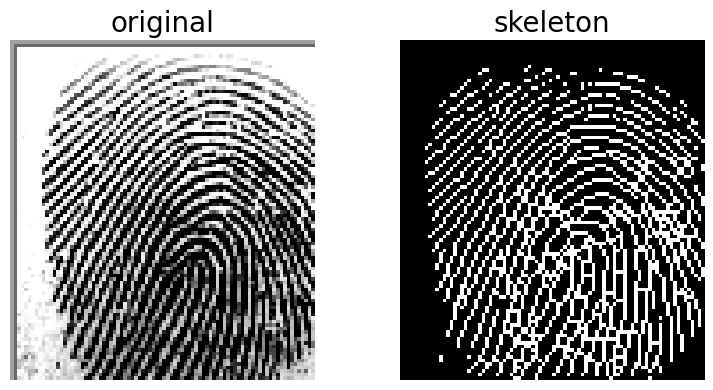

In [9]:
from skimage.morphology import skeletonize
skeleton = skeletonize(bin_img)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap='gray')
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()


## Create arrays of terminations and bifurcations


In [10]:
(rows, cols) = skeleton.shape
minutiaeTerm = np.zeros(skeleton.shape)
minutiaeBif = np.zeros(skeleton.shape)
for i in range(1,rows-1):
    for j in range(1,cols-1):
        #print(skeleton[i,j])
        if(skeleton[i][j]):
            block = skeleton[i-1:i+2,j-1:j+2]
            block_val = np.sum(block)
            if(block_val == 2):
                #print("Term")
                minutiaeTerm[i,j] = 1
            elif(block_val == 4):
                #print("Bifurcation")
                minutiaeBif[i,j] = 1

bifurcations = si.measure.label(minutiaeBif, connectivity=2)
terminations = si.measure.label(minutiaeTerm, connectivity=2)
bifurcations.shape


(96, 86)

In [11]:
regionsBIF = si.measure.regionprops(bifurcations)
regionsTERM = si.measure.regionprops(terminations)
len(regionsBIF)

185

In [12]:
len(regionsTERM)

121

In [13]:
class FeatureVector:
    def __init__(self, x, y, angle, type):
        self.x = x
        self.y = y
        self.angle = angle
        self.type = type

    def __repr__(self):
        return f"FV: {self.type} @ ({self.x},{self.y}) ∠ {self.angle}"

    def asarray(self):
        return [self.x, self.y, self.angle, self.type[0]]
    
    def __eq__(self, other):
        if isinstance(other, FeatureVector):
            return self.x == other.x and self.y == other.y and self.angle == other.angle and self.type == other.type
        return False

    def __hash__(self) -> int:
        return round(self.x*1000000+self.y)

## Calculate angle of minutiaes

In [14]:
def calculateAngles(block, type):
    controlSum = 0
    (blockRow, blockCol) = (block.shape[0], block.shape[1])
    xCenter = (blockRow-1)/2
    yCenter = (blockCol-1)/2
    if type == "bifurcation":
        angles = []
        for i in range(blockRow):
            for j in range(blockCol):
                if (i ==0 or j== 0 or i == blockRow-1 or j== blockRow-1) and block[i][j]:
                    angle =math.degrees(math.atan2(i-xCenter, j-xCenter))
                    controlSum +=1
                    angles.append(angle)
        if controlSum != 3: #is not a bifurcation
            angles = float('nan')
        return angles
    if type == "termination":
        angles = []
        for i in range(blockRow):
            for j in range(blockCol):
                if (i ==0 or j== 0 or i == blockRow-1 or j== blockRow-1) and block[i][j]:
                    angle =math.degrees(math.atan2(i-xCenter, j-xCenter))
                    controlSum +=1
                    angles.append(angle)
                    if controlSum > 1: #is not a termination
                        angles = float('nan')
        return angles


## Save features to vector


In [15]:
Features = []
for region in regionsBIF:
    (row,col) = np.int16(region.centroid)
    block = skeleton[row-1: row+2, col-1:col+2]
    #print(block)
    angles = calculateAngles(block, "bifurcation")
    Features.append(FeatureVector(row, col, angles, "Bifurcation"))

for region in regionsTERM:
    (row,col) = np.int16(region.centroid)
    block = skeleton[row-1: row+2, col-1:col+2]
    #print(block)
    angles = calculateAngles(block, "termination")
    Features.append(FeatureVector(row, col, angles, "Termination"))

In [16]:
def ShowResults(skel, TermLabel, BifLabel): #not work
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = (skel.shape[0], skel.shape[1])
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;
    a_s = np.squeeze(skel)
    print(a_s.shape)
    RP = si.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = si.draw.circle_perimeter(row, col, 1);
        si.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = si.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = si.draw.circle_perimeter(row, col, 1);
        si.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

(96, 86)


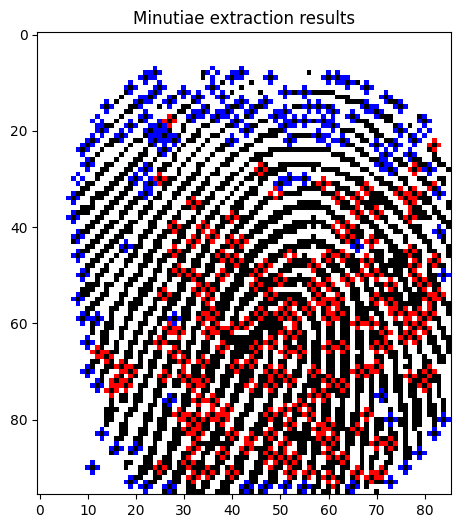

In [17]:
ShowResults(th, terminations, bifurcations)

# Recognizing fingerprints based on extracted minutiae feature vectors

In [18]:
Features[0] # Exemplary 'Bifurcation' feature

FV: Bifurcation @ (18,26) ∠ [0.0, 135.0, 45.0]

In [19]:
Features[-1] # Exemplary 'Termination' feature

FV: Termination @ (94,65) ∠ [-90.0]

## Finger image feature extraction in one function

In [20]:
def extract_finger_feature_vectors(image_path, showResults=False, top=0, bottom=0, left=0, right=0):
    # Get image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop the image
    if not (top==bottom==left==right):
        gray = gray[top:bottom,left:right]

    # Clean-up image a little
    _, th = cv2.threshold(gray,80,255,cv2.THRESH_BINARY)

    # Binarized image 0-255 to binary image 0-1
    th_inv = np.invert(th)
    bin_img = np.array(th_inv/th_inv.max(),dtype=np.uint8)

    # Skeletonize the image
    skeleton = skeletonize(bin_img)

    # Extract features
    (rows, cols) = skeleton.shape
    minutiaeTerm = np.zeros(skeleton.shape)
    minutiaeBif = np.zeros(skeleton.shape)
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            #print(skeleton[i,j])
            if(skeleton[i][j]):
                block = skeleton[i-1:i+2,j-1:j+2]
                block_val = np.sum(block)
                if(block_val == 2):
                    #print("Term")
                    minutiaeTerm[i,j] = 1
                elif(block_val == 4):
                    #print("Bifurcation")
                    minutiaeBif[i,j] = 1

    bifurcations = si.measure.label(minutiaeBif, connectivity=2)
    terminations = si.measure.label(minutiaeTerm, connectivity=2)
    regionsBIF = si.measure.regionprops(bifurcations)
    regionsTERM = si.measure.regionprops(terminations)
    
    Features = []
    for region in regionsBIF:
        (row,col) = np.int16(region.centroid)
        block = skeleton[row-1: row+2, col-1:col+2]
        #print(block)
        angles = calculateAngles(block, "bifurcation")
        Features.append(FeatureVector(row, col, angles, "Bifurcation"))

    for region in regionsTERM:
        (row,col) = np.int16(region.centroid)
        block = skeleton[row-1: row+2, col-1:col+2]
        #print(block)
        angles = calculateAngles(block, "termination")
        Features.append(FeatureVector(row, col, angles, "Termination"))

    if showResults:
        ShowResults(th, terminations, bifurcations)

    return Features

## Recognize fingerprints (brute force - comparing feature vectors)

(96, 86)


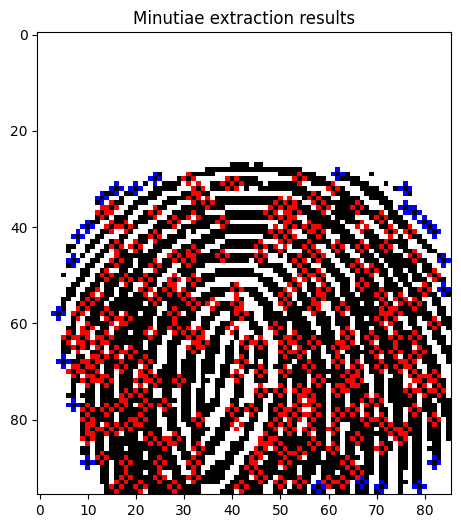

In [24]:
# Get features for first 'real' finger
real_1 = extract_finger_feature_vectors("C:/Users/V4nII/source/repos/Vekz/Fingerprints/Real/1__M_Left_index_finger.BMP", True, 2, 98, 2, 88)

(96, 86)


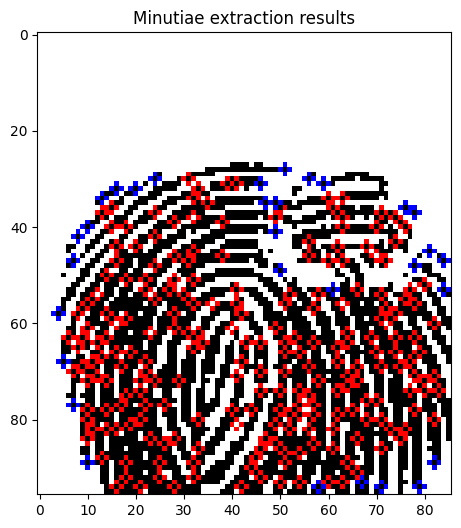

In [25]:
# Get features for first 'altered' finger
altered_1 = extract_finger_feature_vectors("C:/Users/V4nII/source/repos/Vekz/Fingerprints/Altered/1__M_Left_index_finger_CR.BMP", True, 2, 98, 2, 88)

In [26]:
number_of_maximum_features = len(altered_1) if len(altered_1) > len(real_1) else len(real_1)
number_of_similar_features = len(set(real_1) & set(altered_1))
percent_of_similar_features = number_of_similar_features / number_of_maximum_features
print(f"{round(percent_of_similar_features*100, 2)}%")

78.24%


# Fingerprints recognition (CNN)

based on https://www.kaggle.com/code/bilibi/subjectid-finger-cnnrecognizer

## Data loading and preparation

In [27]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [28]:
Altered_data = load_data("./Altered/")
Real_data = load_data("./Real/", train=False)

Loading data from:  ./Altered/
Loading data from:  ./Real/


### Split train data (and create seperate sets for fingers and for people) and prepare crossvalidation set

In [29]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

### Split test data (and create seperate sets for fingers and for people)

In [30]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

### Display datasets shapes after processing

In [31]:
shapes = [
            [X_Altered.shape, y_SubjectID_Altered.shape],
            [X_SubjectID_train.shape, y_SubjectID_train.shape],
            [X_SubjectID_val.shape, y_SubjectID_val.shape],
            [X_test.shape, y_SubjectID_test.shape],
            ['', ''],
            [X_Altered.shape, y_fingerNum_Altered.shape],
            [X_fingerNum_train.shape, y_fingerNum_train.shape],
            [X_fingerNum_val.shape, y_fingerNum_val.shape],
            [X_test.shape, y_fingerNum_test.shape]
        ]

column_labels = ['Feature shape', 'Label shape']
index_label = ['full SubjectID data',
'SubjectID_Train',
'SubjectID_Validation',
'SubjectID_Test',
'',
'full fingerNum data',
'fingerNum_Train',
'fingerNum_Validation',
'fingerNum_Test']

data = pd.DataFrame(data=shapes, index=index_label, columns=column_labels)
data

,Feature shape,Label shape
full SubjectID data,"(17930, 96, 96, 1)","(17930, 600)"
SubjectID_Train,"(14344, 96, 96, 1)","(14344, 600)"
SubjectID_Validation,"(3586, 96, 96, 1)","(3586, 600)"
SubjectID_Test,"(6000, 96, 96, 1)","(6000, 600)"
,,
full fingerNum data,"(17930, 96, 96, 1)","(17930, 10)"
fingerNum_Train,"(14344, 96, 96, 1)","(14344, 10)"
fingerNum_Validation,"(3586, 96, 96, 1)","(3586, 10)"
fingerNum_Test,"(6000, 96, 96, 1)","(6000, 10)"


## Prepare NN models

In [32]:
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                     

## Fit models

In [33]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/20
225/225 [==============================] - 99s 436ms/step - loss: 6.5743 - accuracy: 0.0021 - val_loss: 7.7596 - val_accuracy: 0.0020 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - 98s 437ms/step - loss: 6.4344 - accuracy: 0.0063 - val_loss: 7.4747 - val_accuracy: 0.0028 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - 97s 433ms/step - loss: 6.1987 - accuracy: 0.0157 - val_loss: 6.1578 - val_accuracy: 0.0181 - lr: 1.0000e-04
Epoch 4/20
225/225 [==============================] - 98s 434ms/step - loss: 5.7564 - accuracy: 0.0425 - val_loss: 5.6764 - val_accuracy: 0.0641 - lr: 1.0000e-04
Epoch 5/20
225/225 [==============================] - 97s 433ms/step - loss: 5.0336 - accuracy: 0.1095 - val_loss: 4.9848 - val_accuracy: 0.1640 - lr: 1.0000e-04
Epoch 6/20
225/225 [==============================] - 97s 433ms/step - loss: 4.0250 - accuracy: 0.2443 - val_loss: 4.0631 - val_accuracy: 0.3204 - lr: 1.0000e-04
Epoch 7/20
225/225 [========

In [35]:
model[0].save(f'./results/SubjectID/')

INFO:tensorflow:Assets written to: ./results/SubjectID/assets


INFO:tensorflow:Assets written to: ./results/SubjectID/assets


In [36]:
history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/20
225/225 [==============================] - 96s 425ms/step - loss: 2.0313 - accuracy: 0.3590 - val_loss: 6.4106 - val_accuracy: 0.1018 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - 95s 422ms/step - loss: 1.5009 - accuracy: 0.5038 - val_loss: 2.4175 - val_accuracy: 0.3051 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - 95s 421ms/step - loss: 1.2627 - accuracy: 0.5931 - val_loss: 1.1316 - val_accuracy: 0.6481 - lr: 1.0000e-04
Epoch 4/20
225/225 [==============================] - 95s 420ms/step - loss: 1.0519 - accuracy: 0.6645 - val_loss: 0.9305 - val_accuracy: 0.7326 - lr: 1.0000e-04
Epoch 5/20
225/225 [==============================] - 95s 422ms/step - loss: 0.8638 - accuracy: 0.7336 - val_loss: 0.7701 - val_accuracy: 0.7777 - lr: 1.0000e-04
Epoch 6/20
225/225 [==============================] - 95s 421ms/step - loss: 0.6970 - accuracy: 0.7978 - val_loss: 0.6951 - val_accuracy: 0.8154 - lr: 1.0000e-04
Epoch 7/20
225/225 [========

### Save trained models

In [37]:

model[1].save(f'./results/fingerNum/')

INFO:tensorflow:Assets written to: ./results/fingerNum/assets


INFO:tensorflow:Assets written to: ./results/fingerNum/assets


### Visualize accuracy and loss

Id recognition accuracy:  98.94999861717224 %
Finger recognition accuracy:  99.21666383743286 %


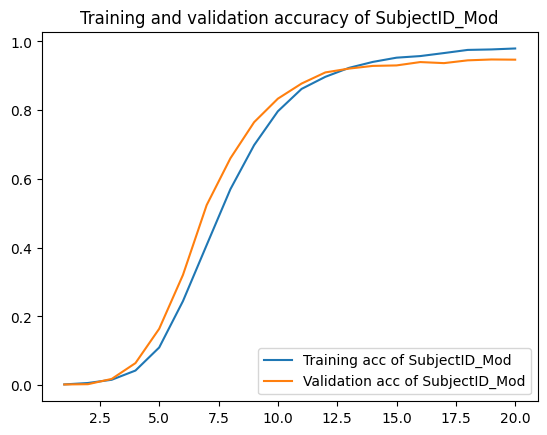

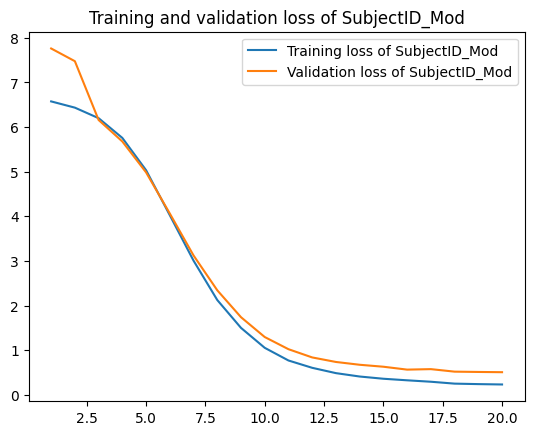

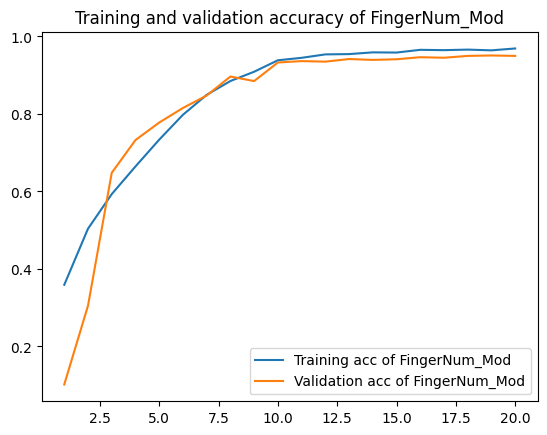

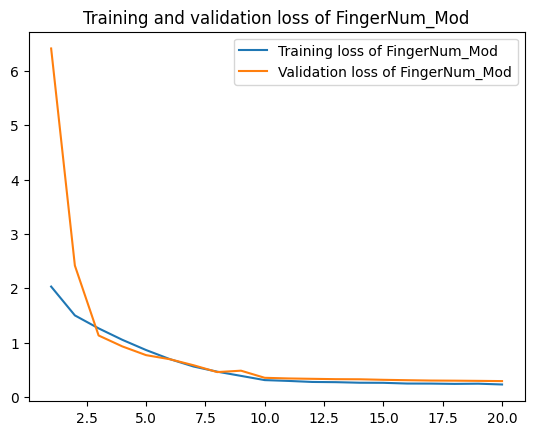

In [38]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

188/188 [==============================] - 11s 57ms/step


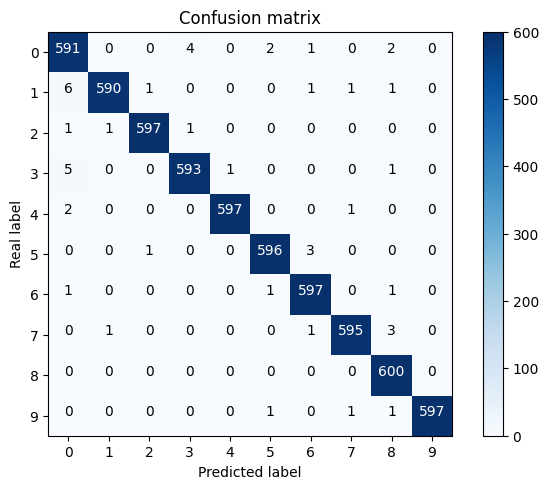

In [40]:
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Predict

188/188 [==============================] - 11s 56ms/step
Infomation confirm! Fingerprint matches: person Id 446 left ring


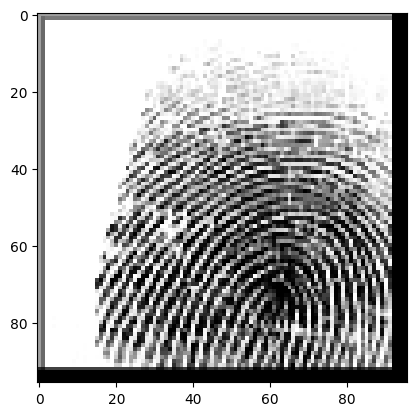

In [42]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")